This Notebook is run a sensitive test between tree-number/diff-inbands to accuracy.<br>

Specifically, we:<br>
1) loop through each inband combination (Spectrum_Indices_Fourier_Terrain_Meteorology);<br>
2) then, loop trhough each tree number (1-120);<br>
3) calculate the accuracy

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import re

##### Read features as dataframes

In [2]:
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [3]:
year_name = [f'Landsat_{year}' for year in year_range[:-2]] + [f'Sentinel_{year}' for year in year_range[-2:]]

In [4]:
# import the points with image values 
feature_df = [pd.read_csv(f'./Data/{name}.csv') for name in year_name]

# merge all pt_with_img and remove unnecessary columns
feature_df = [fe.drop(['system:index','.geo','split'],axis=1) for fe in feature_df]

##### train_test_split and apply randomforest_classifier

In [62]:
grid_acc_list = []
each_year_band_combination = {}

for year,fe in zip(year_range,feature_df):
    
    # _______________________________Different band combination_______________________________
    
    col_name = ''.join(fe.columns)
    
    # find the spectrum band names
    Spectrum_reg = re.compile(r'(B6_VCID_\d|B\d{1,2}|Landsat_B\d{1,2}|Sentinel_B\d{1,2}A?)')
    Spectrum_reg_bands = Spectrum_reg.findall(col_name)
    
    # find the Mean-nomalized names
    Mean_nomalize_reg   = re.compile(r'Mean_\w{2,3}I')
    Mean_nomalize_bands = Mean_nomalize_reg.findall(col_name)
    
    # find the Fourire names
    Fourier_reg   = re.compile(r'((EVI|NDBI|NDVI)_(constant|\w{3}_\d))')
    Fourier_bands = [i[0] for i in Fourier_reg.findall(col_name)]
    
    # get the terrain bands
    Terrain_bands = ['DEM','SLOPE']
    
    # get the meterology bands
    Meterology_bands = ['lrad', 'prec', 'pres', 'shum', 'srad', 'temp', 'wind']

    
    #_________________________________Assess the accuracy ______________________________________
    
    bands_in = zip(['Spectrum',
                    'Spectrum_Normalize',
                    'Spectrum_Normalize_Fourier',
                    'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology'],
                   
                   [Spectrum_reg_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands + Meterology_bands])

    

    each_year_band_combination[year] =  list(bands_in)
    
    # ________________________Grid search to compare the accuracy under different input bands__________
    
    for band_name, bands_select in bands_in:
    
        # get the X and y
        X = fe[bands_select]
        y = fe['Built']

        # appliy RandomForestClassifier 
        classifier = RandomForestClassifier()

        # Use gridSearch
        param_grid = dict(n_estimators = range(1,120))    
        grid = GridSearchCV(classifier,param_grid,cv=4,scoring='accuracy',n_jobs=-1,verbose=2)
        grid.fit(X,y)


        # fetch the accuracy value from grid result
        grid_df = pd.DataFrame(grid.cv_results_)
        grid_select = grid_df[[s for s in grid_df.columns if 'param_' in s or 'split' in s]]
        
        # convert the acc_df to long format and add 'Year' and 'in_band_name' column
        grid_long = pd.DataFrame(grid_select.set_index('param_n_estimators').stack())
        grid_long.reset_index(inplace=True)
        grid_long.columns = ['Tree','CrossFolds','Accuracy']
        grid_long['Year'] = year
        grid_long['In_Bands'] = band_name

        grid_acc_list.append(grid_long)

        # print out the process
        
        print(f'{band_name}_{year}')
        print(f'___________________________________')
        print()
        

##### Save band-combination of each year to disk

In [63]:
# convert the nested dictionary to a df
in_bands_df = pd.DataFrame(each_year_band_combination).T

# iter each row to get dict{name:in-bands}
for row,col in in_bands_df.iterrows():
    # iter each column to get in-bands   
    for i,c in enumerate(col):
        # rewrite each cell with in-bands data
        in_bands_df.at[row,i] = c[1]
 
    
# set the columns names for in_bands_df
in_bands_df.reset_index(inplace=True)

in_bands_df.columns = ['year_range',
                       'Spectrum',
                       'Spectrum_Normalize',
                       'Spectrum_Normalize_Fourier',
                       'Spectrum_Normalize_Fourier_Terrain',
                       'Spectrum_Normalize_Fourier_Terrain_Meterology']

In [64]:
# save the df to disk
in_bands_df.to_csv('./Result/In_bands_combination.csv',index=False)

in_bands_df = pd.read_csv('./Result/In_bands_combination.csv')

##### Save the grid_acc  to disk

In [5]:
# grid_acc = pd.concat(grid_acc_list).reset_index().drop('index',axis = 1)
# grid_acc['Year'] = grid_acc['Year'].astype('category')
# grid_acc.to_csv('./Result/Grid_acc_tree.csv',index = False)

# load the grid_acc
grid_acc = pd.read_csv('./Result/Grid_acc_tree.csv')
grid_acc['Year'] = grid_acc['Year'].astype('category')

In [6]:
grid_acc

,Tree,CrossFolds,Accuracy,Year,In_Bands
0,1,split0_test_score,0.784182,1990_1992,Spectrum
1,1,split1_test_score,0.781355,1990_1992,Spectrum
2,1,split2_test_score,0.754527,1990_1992,Spectrum
3,1,split3_test_score,0.773307,1990_1992,Spectrum
4,2,split0_test_score,0.748660,1990_1992,Spectrum
...,...,...,...,...,...
23795,118,split3_test_score,0.947786,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23796,119,split0_test_score,0.936592,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23797,119,split1_test_score,0.948481,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23798,119,split2_test_score,0.952444,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology


##### Observe that the tree number of 100 is enough for classification

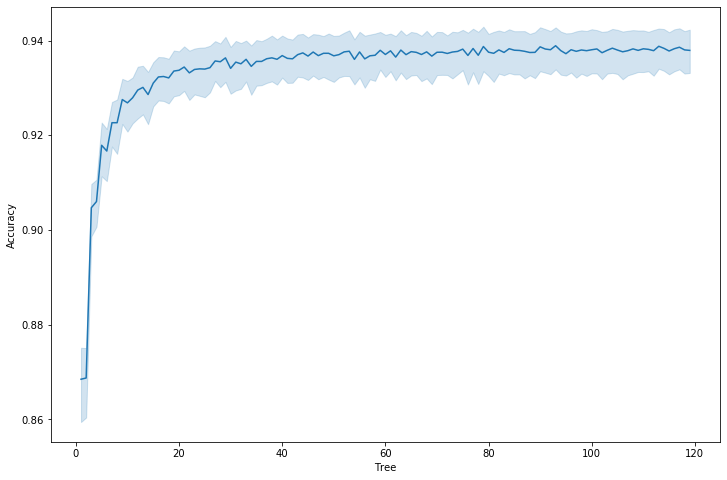

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc[grid_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology'],
             x='Tree',
             y='Accuracy')

##### Observe that the Fourier bands significant increases the accuracy

In [9]:
# get the accuracy with the tree number of 100
Acc_tree_100 = grid_acc[grid_acc['Tree'] == 100]

In [10]:
Acc_tree_100

,Tree,CrossFolds,Accuracy,Year,In_Bands
396,100,split0_test_score,0.839812,1990_1992,Spectrum
397,100,split1_test_score,0.845741,1990_1992,Spectrum
398,100,split2_test_score,0.834339,1990_1992,Spectrum
399,100,split3_test_score,0.849095,1990_1992,Spectrum
872,100,split0_test_score,0.866622,1990_1992,Spectrum_Normalize
...,...,...,...,...,...
23247,100,split3_test_score,0.942498,2017_2019,Spectrum_Normalize_Fourier_Terrain
23720,100,split0_test_score,0.935931,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23721,100,split1_test_score,0.948481,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology
23722,100,split2_test_score,0.950462,2017_2019,Spectrum_Normalize_Fourier_Terrain_Meterology


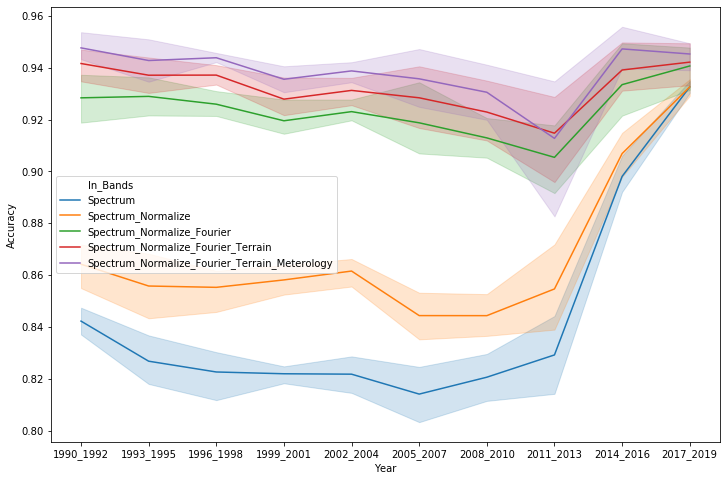

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Acc_tree_100,
             x='Year',
             y='Accuracy',
             hue = 'In_Bands')

##### Just for fun: Use ANN(tf) to construct to classification moedl

In [5]:
# get one df for trying
fe = feature_df[-1]

# get the X and y
X = fe.drop('Built',1)
y = fe['Built']

# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# reshape the y values 
y_train = y_train.values.reshape([-1,1])
y_test = y_test.values.reshape([-1,1])

In [7]:
# scale the X values 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [8]:
# construct the ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [9]:
# built layers 
model = Sequential()

model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(2,activation='relu'))

model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [10]:
# fit the model with X and y
model.fit(x=X_train,y=y_train,epochs=100,validation_data=(X_test,y_test))

Train on 4056 samples, validate on 1999 samples
Epoch 1/100
4056/4056 [==============================] - 1s 242us/sample - loss: 0.6090 - accuracy: 0.6923 - val_loss: 0.5148 - val_accuracy: 0.8579
Epoch 2/100
4056/4056 [==============================] - 0s 52us/sample - loss: 0.4454 - accuracy: 0.8713 - val_loss: 0.3811 - val_accuracy: 0.8934
Epoch 3/100
4056/4056 [==============================] - 0s 52us/sample - loss: 0.3092 - accuracy: 0.8969 - val_loss: 0.2732 - val_accuracy: 0.9015
Epoch 4/100
4056/4056 [==============================] - 0s 50us/sample - loss: 0.2566 - accuracy: 0.9011 - val_loss: 0.2527 - val_accuracy: 0.9050
Epoch 5/100
4056/4056 [==============================] - 0s 52us/sample - loss: 0.2379 - accuracy: 0.9120 - val_loss: 0.2349 - val_accuracy: 0.9130
Epoch 6/100
4056/4056 [==============================] - 0s 50us/sample - loss: 0.2264 - accuracy: 0.9122 - val_loss: 0.2397 - val_accuracy: 0.9070
Epoch 7/100
4056/4056 [==============================] - 0s 51u

Epoch 56/100
4056/4056 [==============================] - 0s 50us/sample - loss: 0.1365 - accuracy: 0.9532 - val_loss: 0.1566 - val_accuracy: 0.9450
Epoch 57/100
4056/4056 [==============================] - 0s 49us/sample - loss: 0.1422 - accuracy: 0.9477 - val_loss: 0.1499 - val_accuracy: 0.9455
Epoch 58/100
4056/4056 [==============================] - 0s 50us/sample - loss: 0.1376 - accuracy: 0.9507 - val_loss: 0.1447 - val_accuracy: 0.9485
Epoch 59/100
4056/4056 [==============================] - 0s 51us/sample - loss: 0.1383 - accuracy: 0.9512 - val_loss: 0.1433 - val_accuracy: 0.9480
Epoch 60/100
4056/4056 [==============================] - 0s 50us/sample - loss: 0.1276 - accuracy: 0.9546 - val_loss: 0.1507 - val_accuracy: 0.9410
Epoch 61/100
4056/4056 [==============================] - 0s 48us/sample - loss: 0.1291 - accuracy: 0.9549 - val_loss: 0.2029 - val_accuracy: 0.9255
Epoch 62/100
4056/4056 [==============================] - 0s 57us/sample - loss: 0.1394 - accuracy: 0.9477

In [ ]:
# plot the losses
losses = pd.DataFrame(model.history.history)

In [17]:
val_accuracy = losses['val_accuracy']

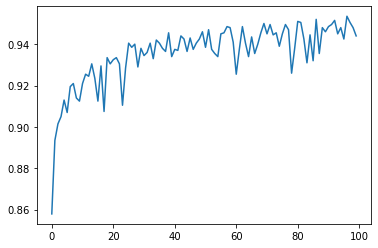

In [18]:
val_accuracy.plot()

In [86]:
# let's see the performance of the modle
from sklearn.metrics import classification_report,confusion_matrix
pred = model.predict_classes(X_test)

In [87]:
# print the classification report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1011
           1       0.94      0.96      0.95       988

    accuracy                           0.95      1999
   macro avg       0.95      0.95      0.95      1999
weighted avg       0.95      0.95      0.95      1999



In [88]:
# print the confusin matrix
print(confusion_matrix(y_test,pred))

[[945  66]
 [ 35 953]]
